In [1]:
# I load the needed libraries
library(dplyr)
library(scales)
library(ggplot2)
library(rjags)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



# Exercise 1

Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following to sets of observations taken over a fixed large time interval in two different corps:

| y death soldiers | 0 | 1 | 2 | 3 | 4 | ≥ 5 |
|---|---|---|---|---|---|---|
| n1 observations | 109 | 65 | 22 | 3 | 1 | 0 |
| n2 observations | 144 | 91 | 32 | 11 | 2 | 0 |

- assuming a uniform prior, compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.

- assuming now a Jeffreys’ prior: $$g(λ) ∝ 1/√λ , with λ > 0 $$ compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.

In [2]:
# I download the data into an array and convert it to matrix
data = c(109, 65, 22, 3, 1, 0, 144, 91, 32, 11, 2, 0)
data = matrix(data, nrow = 2, byrow = TRUE)

# Graphical standard
options(repr.plot.width=20, repr.plot.height=8)


In [3]:
# I define the credibility interval limits
limit = 0.95
CI = c((1-limit)/2, 1-(1-limit)/2)

# and I create a function that performs a loop on the corps using the uniform prior
get_posterior = function (prior, lambdas, delta, corp=1) {

    # To evaluate the posterior I have to multiply the indipendent Poisson processes
    likelihood = rep(0, length(lambdas))
    for (i in 1:length(lambdas)) {
        likelihood[i] = get_poiss_likelihood(lambdas[i], data[corp,])
    }

    # Evaluating the posterior and normalize it in the discrete way
    posterior = likelihood*prior
    posterior = posterior/sum(posterior)/delta_lambda

    return (posterior)
}

get_poiss_likelihood = function (lambda0, data_in) {
    # Take the likelihood value for that particolar value of lambda
    
    likelihood = 1
    for (i in 1:length(data_in)) {
        for (j in 1:data_in[i]) {
            likelihood = likelihood * dpois(i-1, lambda0)
        }
    }
    return(likelihood)
}

# And one to evaluate the parameter
get_lambda = function (x, posterior, delta) {
    lambda = x*posterior*delta
    return(sum(lambda))
}

# And finally one to evaluate the credibility interval
get_CI = function (posterior, delta, CI = c(0.025, 0.975)) {
    not_yet = TRUE; cum_prob = 0; index_CI = c(0, 0)
    for (i in 1:length(posterior)) {
        cum_prob = cum_prob + posterior[i]*delta
        if (cum_prob > CI[1] & not_yet) {
            index_CI[1] = i
            not_yet = FALSE
        } else if (cum_prob > CI[2]) {
            index_CI[2] = i
            break
        }
    }
    return(index_CI)
}

Now I can use the formulas and find the posterior with the uniform prior

In [4]:
# Now I use the defined functions to evaluate the uniform prior
resolution = 1000
delta_lambda = 1/resolution
lambdas = seq(from = 0, to = 2, length.out = resolution)
unif_prior = rep(1, length(lambdas))

unif_post = matrix(c(get_posterior(unif_prior, lambdas, delta_lambda, corp = 1),
                    get_posterior(unif_prior, lambdas, delta_lambda, corp = 2)),
                    nrow = 2, byrow = TRUE)

unif_lambda = c(get_lambda(lambdas, unif_post[1,], delta_lambda), get_lambda(lambdas, unif_post[2,], delta_lambda))

unif_CI_1 = c(get_CI(unif_post[1,], delta_lambda))
unif_CI_2 = c(get_CI(unif_post[2,], delta_lambda))

cat("The parameter of the posterior distribution is", round(unif_lambda[1], 3), "for the first corp and", round(unif_lambda[2], 3), "for the second one")


The parameter of the posterior distribution is 0.658 for the first corp and 0.734 for the second one

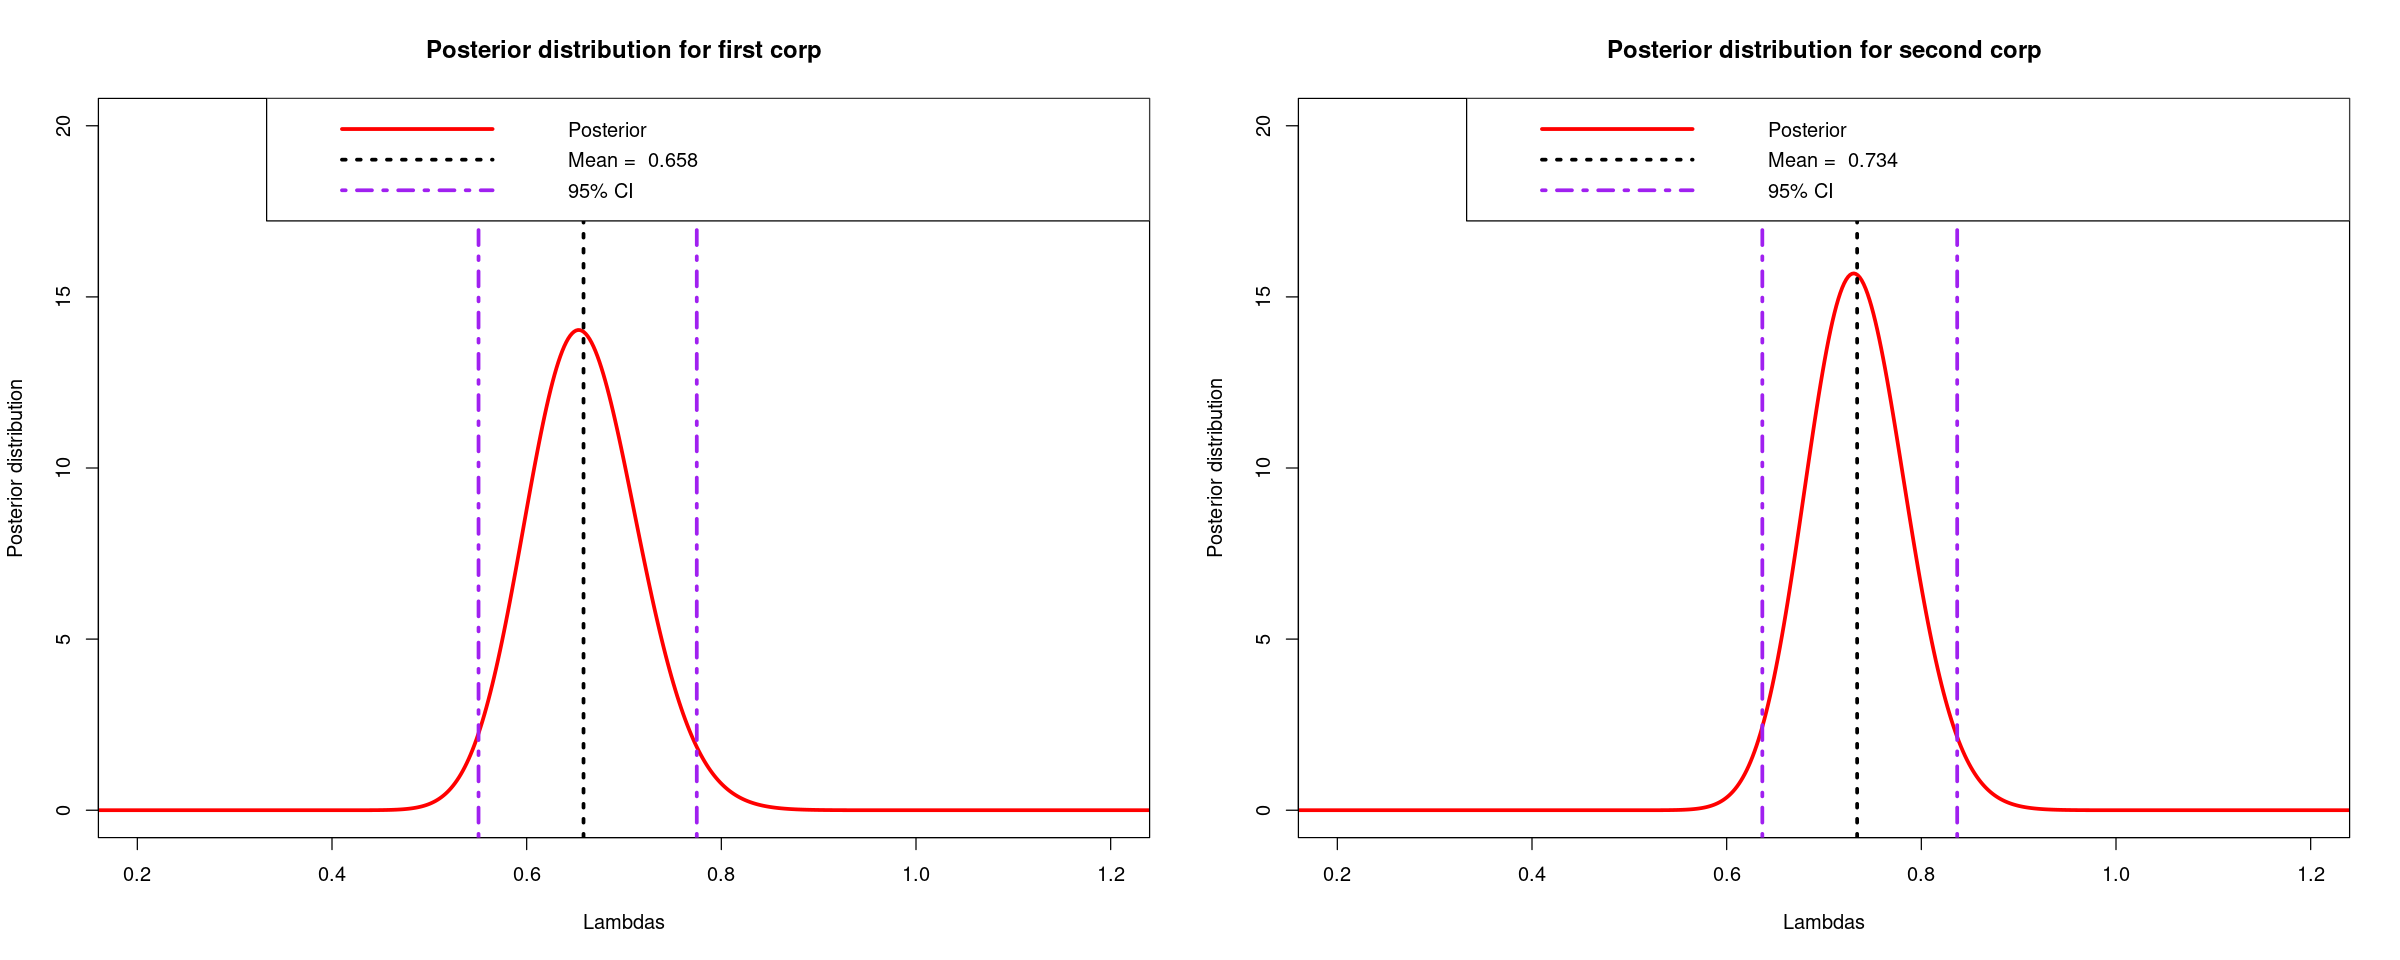

In [5]:
# Plotting the result for having a graphical view
par(mfrow=c(1,2), oma = c(0, 0, 0, 0))

plot(lambdas, unif_post[1,], type = 'l', lwd = 3, col = 'red', xlab = 'Lambdas', ylab = 'Posterior distribution', xlim = c(0.2, 1.2), ylim = c(0, 20),
        main = 'Posterior distribution for first corp')
abline(v = unif_lambda[1], col = 'black', lwd = 3, lty = 3)
abline(v = lambdas[unif_CI_1], col = 'purple', lwd = 3, lty = 4)
legend("topright", legend = c("Posterior", paste("Mean = ", round(unif_lambda[1], 3)), "95% CI"), col = c("red", "black", "purple"),
        lty = c(1, 3, 4), lwd = c(3, 3, 3))

plot(lambdas, unif_post[2,], type = 'l', lwd = 3, col = 'red', xlab = 'Lambdas', ylab = 'Posterior distribution', xlim = c(0.2, 1.2), ylim = c(0, 20),
        main = 'Posterior distribution for second corp')
abline(v = unif_lambda[2], col = 'black', lwd = 3, lty = 3)
abline(v = lambdas[unif_CI_2], col = 'purple', lwd = 3, lty = 4)
legend("topright", legend = c("Posterior", paste("Mean = ", round(unif_lambda[2], 3)), "95% CI"), col = c("red", "black", "purple"),
        lty = c(1, 3, 4), lwd = c(3, 3, 3))


And then I do the same for the Jeffrey's prior

In [6]:
# And I do the same for a Jeffrey's prior
resolution = 1000
eps = 1e-10
delta_lambda = 1/resolution
lambdas = seq(from = 0+delta_lambda, to = 2+delta_lambda, length.out = resolution)
jeff_prior = dbeta(0.2*lambdas, shape1 = 0.5, shape2 = 0.5)

jeff_post = matrix(c(get_posterior(jeff_prior, lambdas, delta_lambda, corp = 1),
                    get_posterior(jeff_prior, lambdas, delta_lambda, corp = 2)),
                    nrow = 2, byrow = TRUE)


jeff_lambda = c(get_lambda(lambdas, jeff_post[1,], delta_lambda), get_lambda(lambdas, jeff_post[2,], delta_lambda))

jeff_CI_1 = c(get_CI(jeff_post[1,], delta_lambda))
jeff_CI_2 = c(get_CI(jeff_post[2,], delta_lambda))

cat("The parameter of the posterior distribution is", round(jeff_lambda[1], 3), "for the first corp and", round(jeff_lambda[2], 3), "for the second one")


The parameter of the posterior distribution is 0.656 for the first corp and 0.733 for the second one

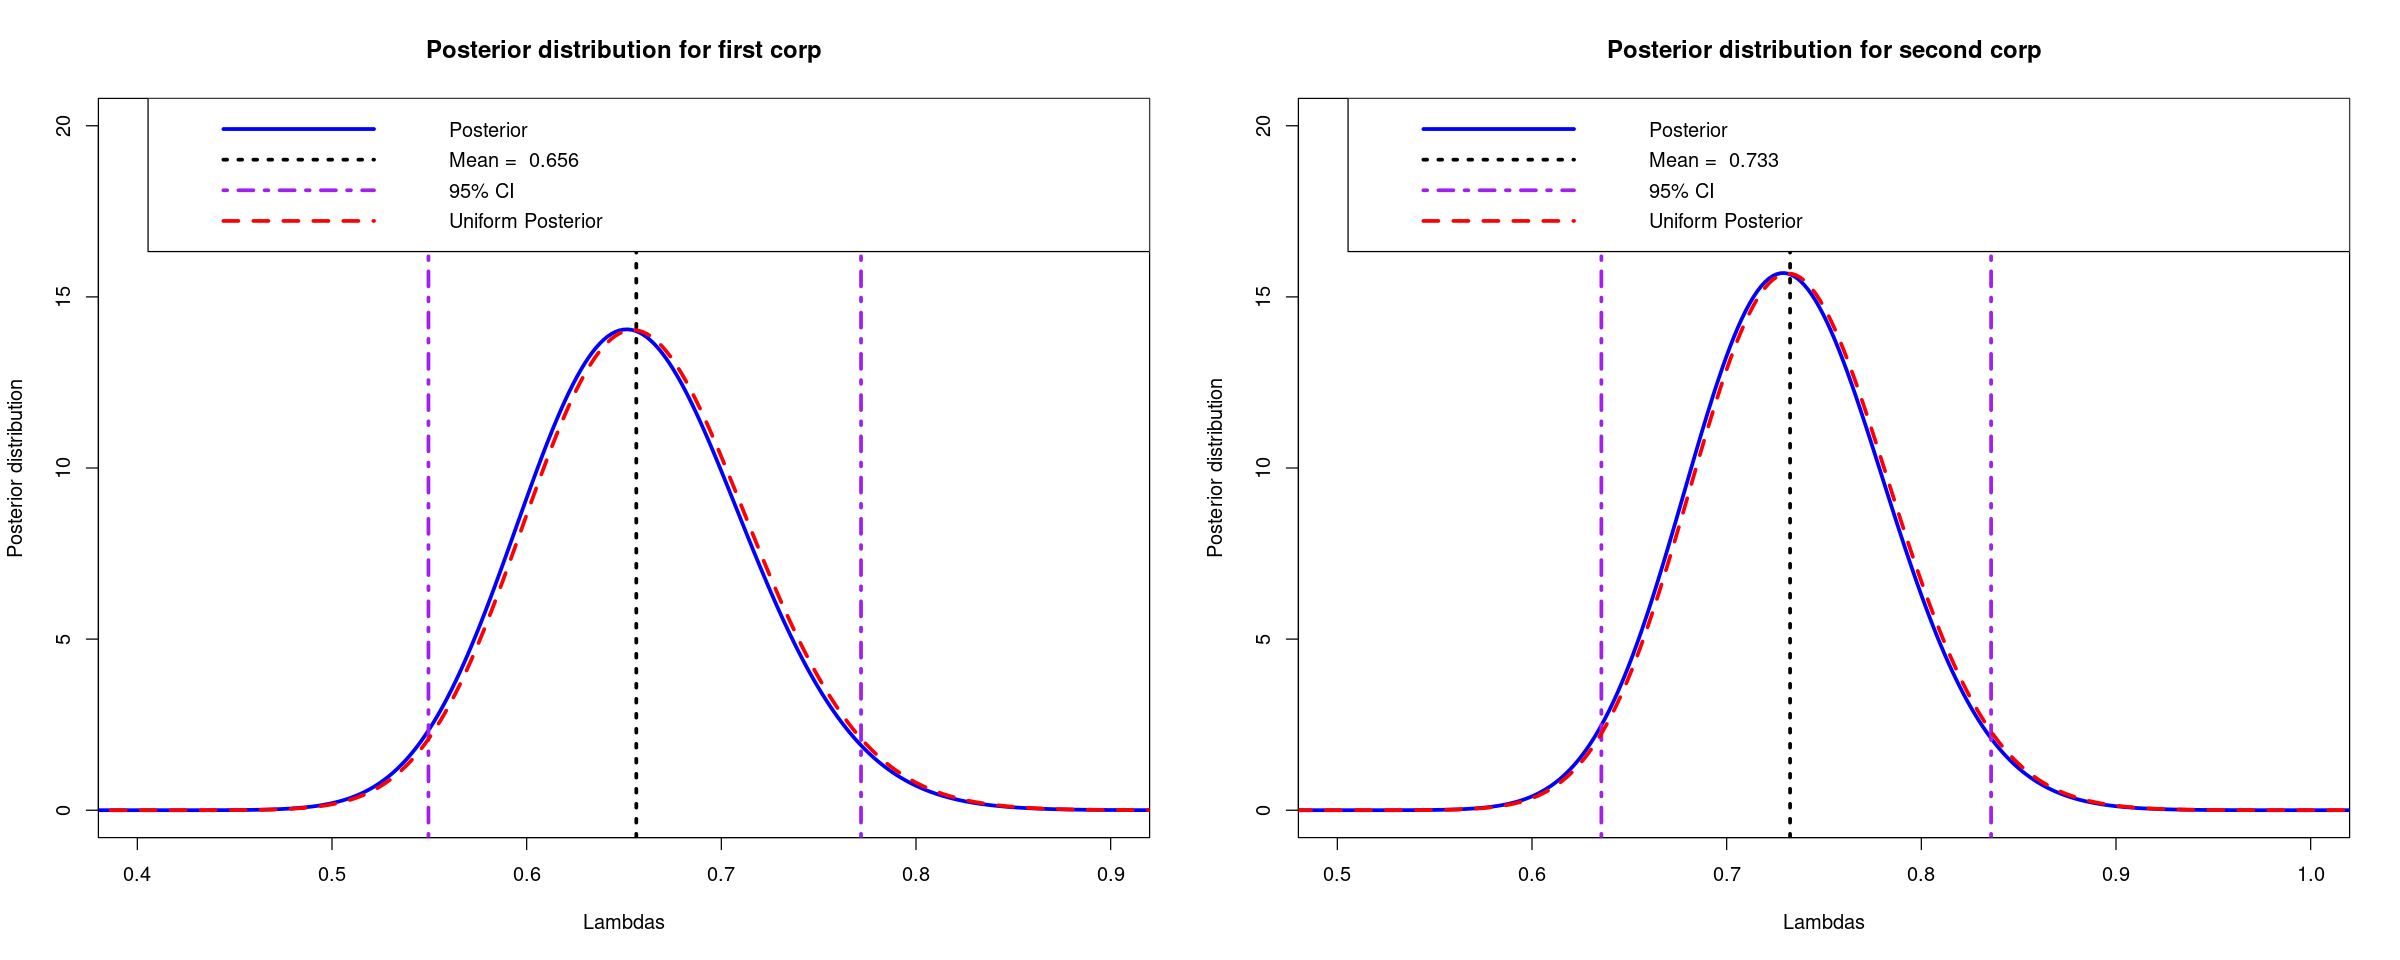

In [7]:
# Plotting the result for having a graphical view (overlapping also the posteriorfound with the uniform prior)
par(mfrow=c(1,2), oma = c(0, 0, 0, 0))

plot(lambdas, jeff_post[1,], type = 'l', lwd = 3, col = 'blue', xlab = 'Lambdas', ylab = 'Posterior distribution', xlim = c(0.4, 0.9), ylim = c(0, 20),
        main = 'Posterior distribution for first corp')
abline(v = jeff_lambda[1], col = 'black', lwd = 3, lty = 3)
abline(v = lambdas[jeff_CI_1], col = 'purple', lwd = 3, lty = 4)
lines(lambdas, unif_post[1,], type = 'l', lwd = 3, lty = 2, col = 'red')
legend("topright", legend = c("Posterior", paste("Mean = ", round(jeff_lambda[1], 3)), "95% CI", "Uniform Posterior"), col = c("blue", "black", "purple", "red"),
        lty = c(1, 3, 4, 2), lwd = c(3, 3, 3, 3))



plot(lambdas, jeff_post[2,], type = 'l', lwd = 3, col = 'blue', xlab = 'Lambdas', ylab = 'Posterior distribution', xlim = c(0.5, 1), ylim = c(0, 20),
        main = 'Posterior distribution for second corp')
abline(v = jeff_lambda[2], col = 'black', lwd = 3, lty = 3)
abline(v = lambdas[jeff_CI_2], col = 'purple', lwd = 3, lty = 4)
lines(lambdas, unif_post[2,], type = 'l', lwd = 3, lty = 2, col = '#FF0000')
legend("topright", legend = c("Posterior", paste("Mean = ", round(jeff_lambda[2], 3)), "95% CI", "Uniform Posterior"), col = c("blue", "black", "purple", "red"),
        lty = c(1, 3, 4, 2), lwd = c(3, 3, 3, 3))



# Exercise 2

Solve Exercise 1 with a Markov Chain Monte Carlo. Build your own MCMC, using the functions introduced during lectures, or using a MCM library like JAGS

I will proceed with the implementation of the functions seen in class, in order to obtain the two posterior distribution of the previous exercise, evaluated as the product of the two priors with the poisson likelihood. From theory I know that the two posterior are:

$$
\mathbb{P}(\mu | \{y_j\}) \propto

\begin{cases}
\mu^{\sum y_j} e^{-n \mu} = \text{Gamma} \left( \alpha = \sum y_j +1, \lambda = n\right) \hspace{1.45 cm} \text{For uniform prior} \\
\mu^{\sum y_j - \frac{1}{2}} e^{-n \mu} = \text{Gamma} \left( \alpha = \sum y_j +\frac{1}{2}, \lambda = n\right) \hspace{1 cm} \text{For Jeffrey's prior}
\end{cases}
$$

In [8]:
# I declare the theorical parameters
sum_y_i = c(sum(data[1,]*(0:5)), sum(data[2,]*(0:5)))
n = c(sum(data[1,]), sum(data[2,]))

# Function to be plotted:
posterior_unif = function (lambda) {
    return (dgamma(lambda, sum_y_i + 1, n))
}

posterior_jeff = function (lambda) {
    return (dgamma(lambda, sum_y_i + 0.5, n))
}

# This function is ment to return the sequence of the samples for a determined function
random_steps = function (func_wanted, theta_init, n_samples, func_change, sigma, corp = 1) {
    # Initilalizing the parameters
    current_theta = theta_init[corp]
    current_function = func_wanted(theta_init[corp])[corp]
    samples = matrix(data = NA, nrow = n_samples, ncol = 2)

    # For statistical purposes
    accepted = 0

    # Evolution loop
    for (n in 1:n_samples) {
        # Take a guessed new theta and evaluate its probability
        guessed_theta = func_change(current_theta, sigma[corp])
        guessed_function = func_wanted(guessed_theta)[corp]

        # Acceptance conditions
        if ((guessed_function > current_function) || ((guessed_function/current_function) > runif(1))) {
            current_theta = guessed_theta
            current_function = guessed_function
            accepted = accepted + 1
        }

        # Saving the generated samples
        samples[n, 1] = current_function
        samples[n, 2] = current_theta
    }

    cat("Acceptance rate = ", round(accepted/n_samples, 5), '\n')

    return(samples)
}

# I decide to use a gaussian function to generate the guessed new parameters in the MCMC
generation_function = function (x0, std) {
    return(rnorm(n = 1, mean = x0, sd = std))
}



Now I can run the MCMC on the posterior given by the Uniform prior 

In [9]:
# For the Uniform prior
lambda0 = c(1, 1)
std = c(0.1, 0.1)
N = as.integer(1e5)

uniform_chain_1 = random_steps(func_wanted = posterior_unif, theta_init = lambda0, n_samples = N, func_change = generation_function, sigma = std, corp = 1)
uniform_chain_2 = random_steps(func_wanted = posterior_unif, theta_init = lambda0, n_samples = N, func_change = generation_function, sigma = std, corp = 2)


Acceptance rate =  0.53072 
Acceptance rate =  0.50393 


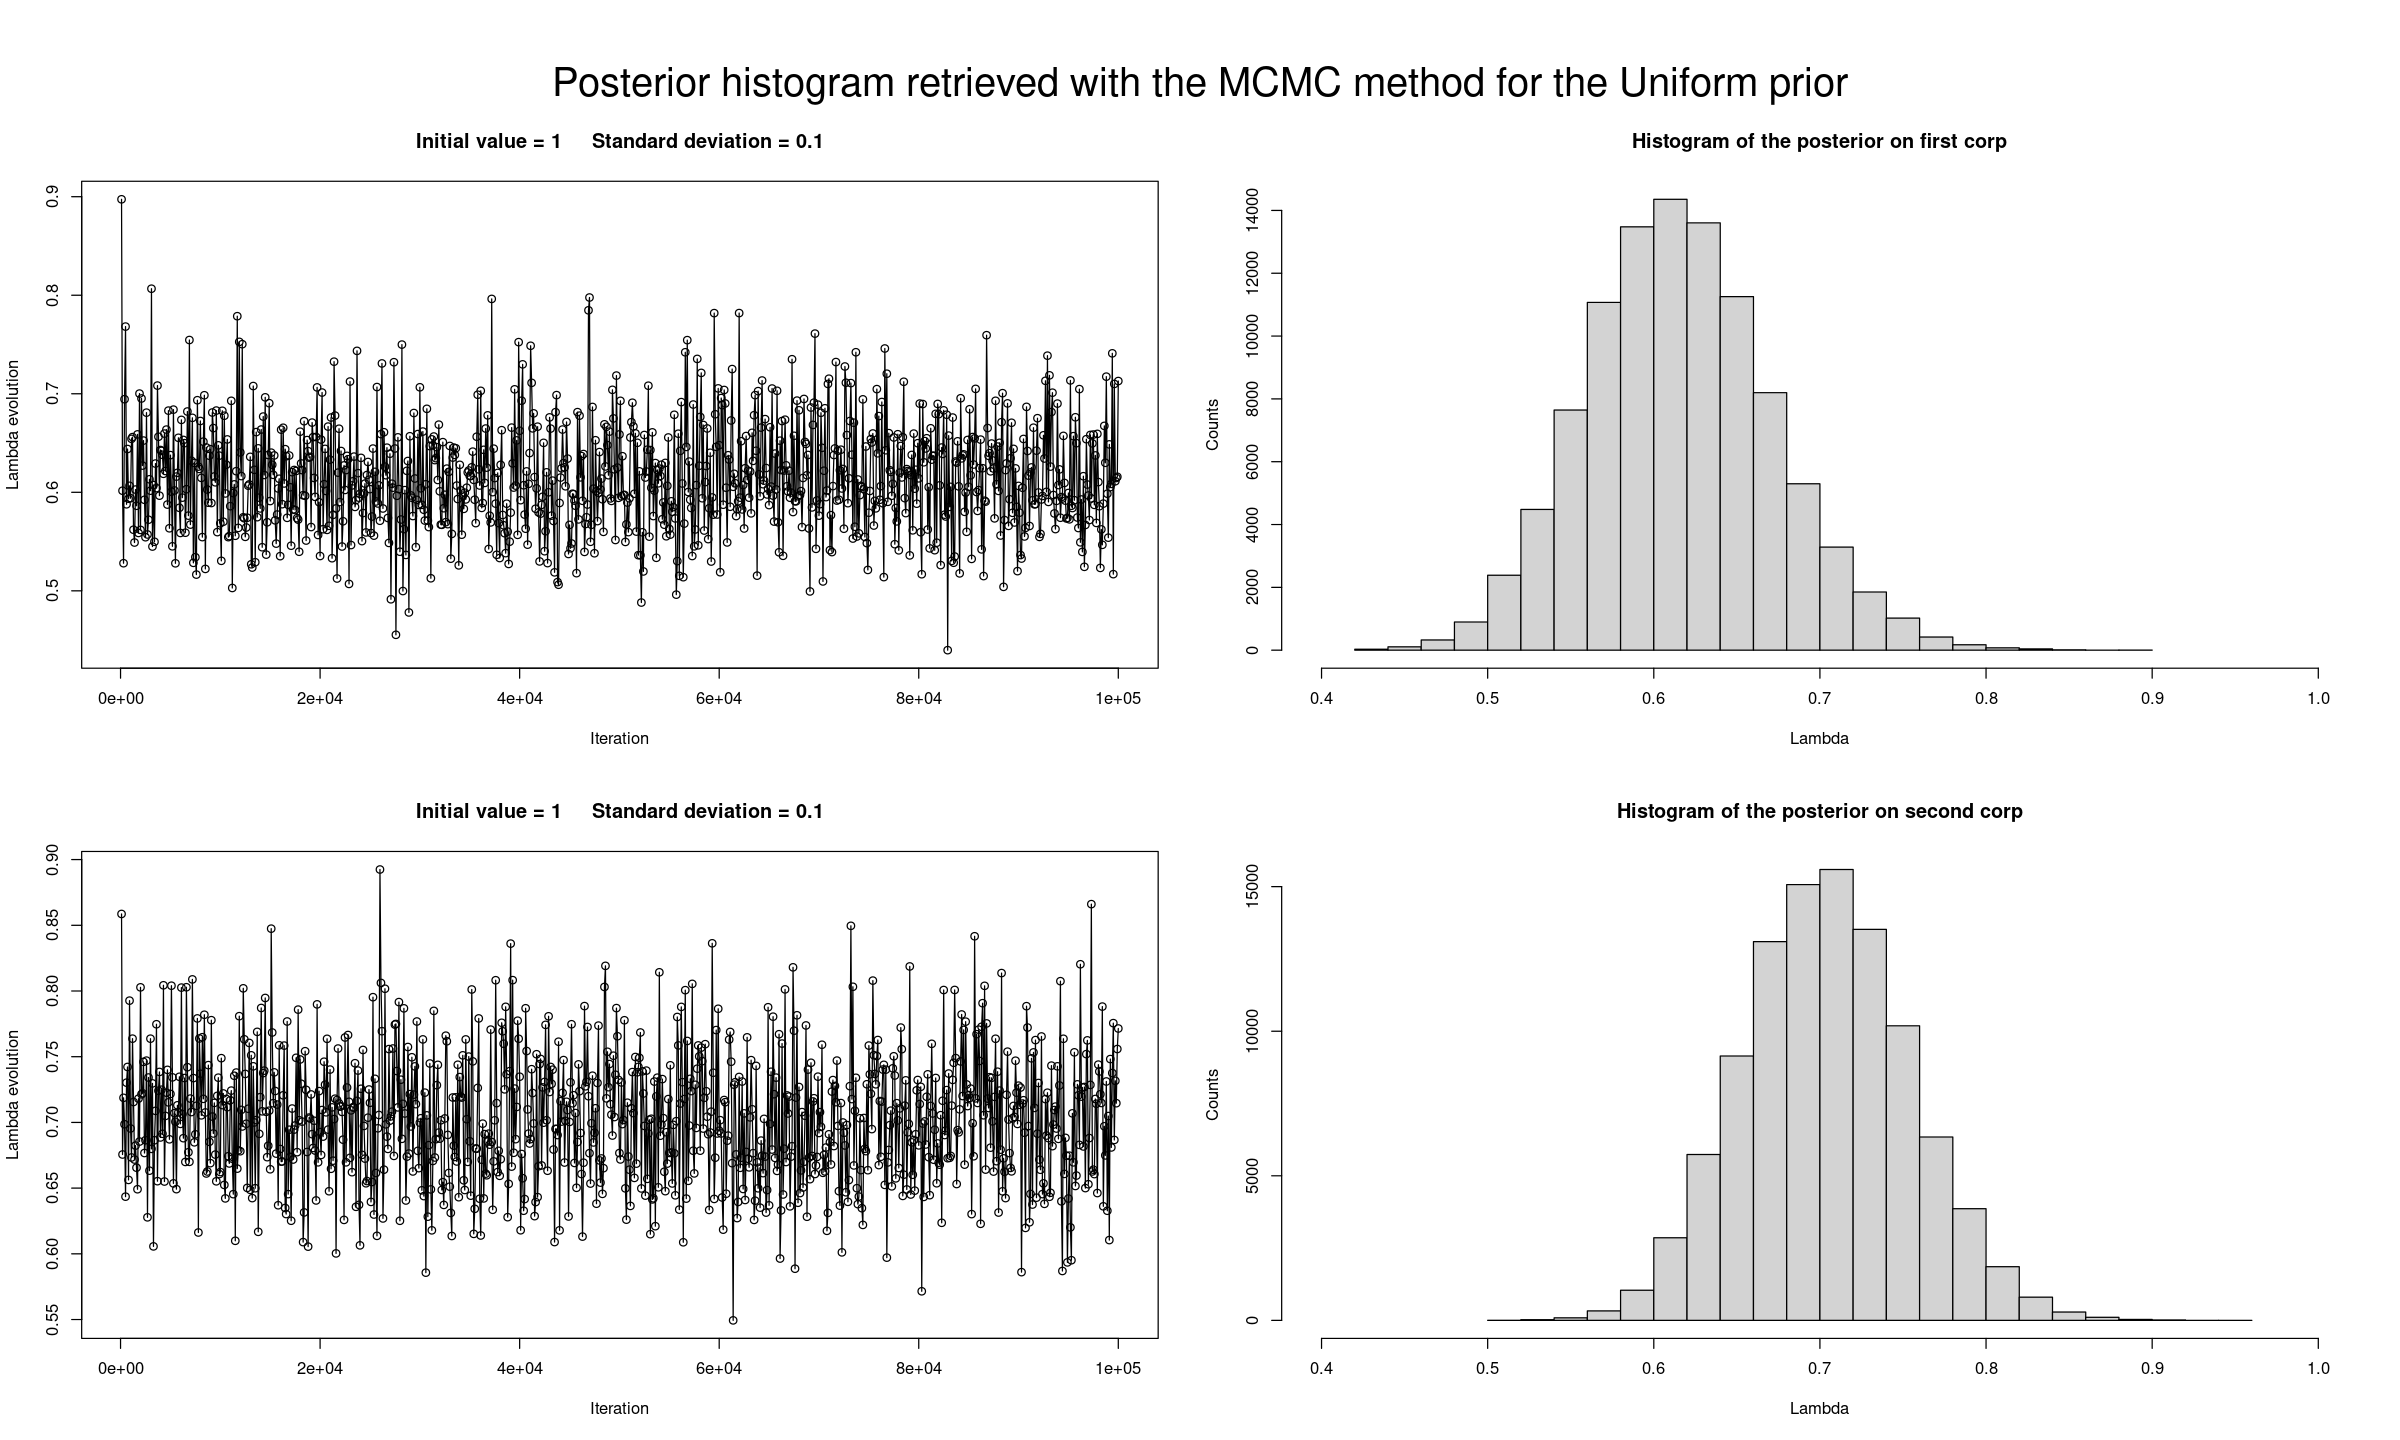

In [10]:
# Printing then the evolution of the chain and the resulting distribution
par(mfrow=c(2,2), oma = c(0, 0, 5, 0))
options(repr.plot.width=20, repr.plot.height=12)

steps = 100

uniform_plot_1 = uniform_chain_1[seq(1, length(uniform_chain_1[,2]), steps),2]
plot(1:length(uniform_plot_1)*steps, uniform_plot_1, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Lambda evolution',
        main = paste0('Initial value = ', lambda0[1], '     Standard deviation = ', std[1]))
hist(uniform_chain_1[,2], breaks = 30, xlab = 'Lambda', ylab = 'Counts', main = 'Histogram of the posterior on first corp', xlim = c(0.4, 1))

uniform_plot_2 = uniform_chain_2[seq(1, length(uniform_chain_2[,2]), steps),2]
plot(1:length(uniform_plot_2)*steps, uniform_plot_2, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Lambda evolution',
        main = paste0('Initial value = ', lambda0[1], '     Standard deviation = ', std[1]))
hist(uniform_chain_2[,2], breaks = 30, xlab = 'Lambda', ylab = 'Counts', main = 'Histogram of the posterior on second corp', xlim = c(0.4, 1))

mtext("Posterior histogram retrieved with the MCMC method for the Uniform prior", outer = TRUE, cex = 2, font = 1)


And then do the same for the Jeffrey's prior

In [11]:
# For the Jeffrey's prior
lambda0 = c(0.5, 0.5)
std = c(0.1, 0.1)
N = as.integer(1e5)

jeff_chain_1 = random_steps(func_wanted = posterior_jeff, theta_init = lambda0, n_samples = N, func_change = generation_function, sigma = std, corp = 1)
jeff_chain_2 = random_steps(func_wanted = posterior_jeff, theta_init = lambda0, n_samples = N, func_change = generation_function, sigma = std, corp = 2)


Acceptance rate =  0.53164 
Acceptance rate =  0.5 


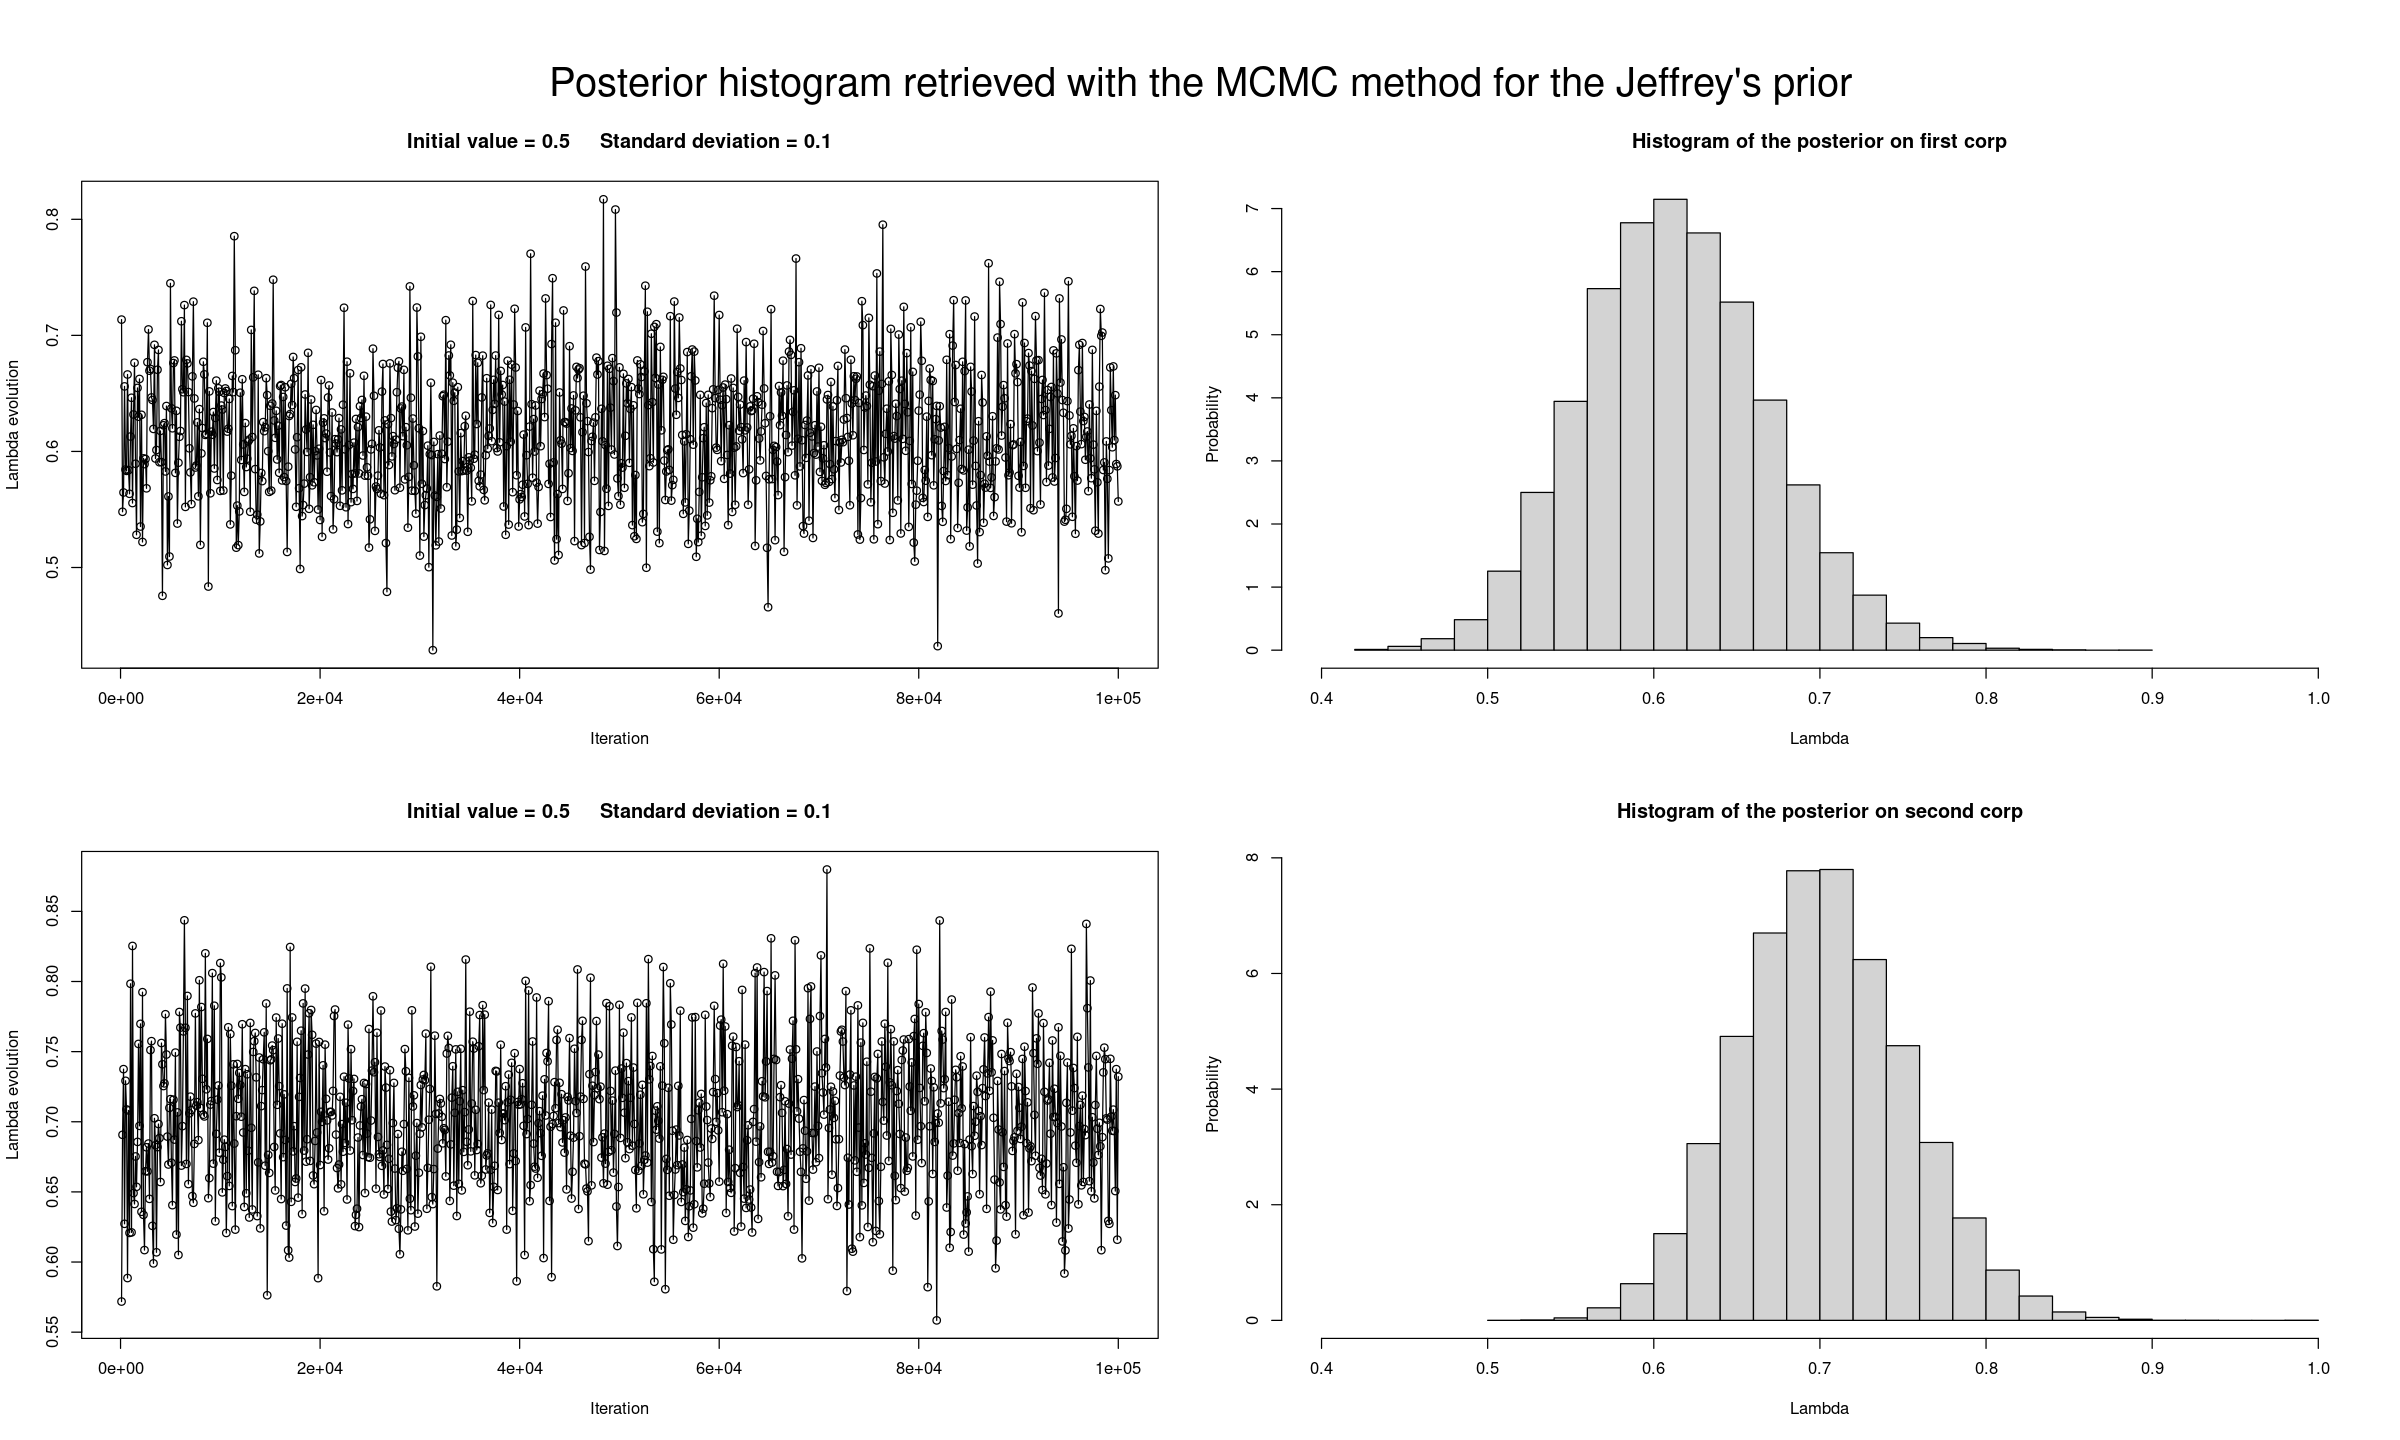

In [12]:
# Printing then the evolution of the chain and the resulting distribution
par(mfrow=c(2,2), oma = c(0, 0, 5, 0))
options(repr.plot.width=20, repr.plot.height=12)

# I plot the chain every 100 steps, in order to have a more visible graph
steps = 100

jeff_plot_1 = jeff_chain_1[seq(1, length(jeff_chain_1[,2]), steps),2]
plot(1:length(jeff_plot_1)*steps, jeff_plot_1, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Lambda evolution',
        main = paste0('Initial value = ', lambda0[1], '     Standard deviation = ', std[1]))
hist(jeff_chain_1[,2], breaks = 30, xlab = 'Lambda', ylab = 'Probability', main = 'Histogram of the posterior on first corp', xlim = c(0.4, 1), freq = FALSE)

jeff_plot_2 = jeff_chain_2[seq(1, length(jeff_chain_2[,2]), steps),2]
plot(1:length(jeff_plot_2)*steps, jeff_plot_2, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Lambda evolution',
        main = paste0('Initial value = ', lambda0[1], '     Standard deviation = ', std[1]))
hist(jeff_chain_2[,2], breaks = 30, xlab = 'Lambda', ylab = 'Probability', main = 'Histogram of the posterior on second corp', xlim = c(0.4, 1), freq = FALSE)

mtext("Posterior histogram retrieved with the MCMC method for the Jeffrey's prior", outer = TRUE, cex = 2, font = 1)


# Exercise 3

A study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per $100 ml$ of stream water. A total of $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high bacter X level. Indicating with $p$ the probability that a sample of water taken from the stream has a high bacter X level,

- find the frequentist estimator for $p$
- using a $\text{Beta}(1, 10)$ prior for $p$, calculate a posterior distribution $P (p∣y)$
- find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval
- test the hypotesis $H_1, H_0$ at $5\%$ level of significance with both the frequentist and bayesian approach:
$$ H_0 : p = 0.1 \\ H_1 : p \neq 0.1 $$


A new measurement, performed one month later on $n = 165$ water samples, gives $y = 9$ high bacter X level,

- find the frequentist estimator for $p$
- find a bayesian estimator for $p$, assuming both a Beta(1, 10) prior for $p$, and assuming the posterior probability of the older measurement as the prior for the new one
- find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval
- test the hypotesis $H_1, H_0$ at $5\%$ level of significance with both the frequentist and bayesian approach:
$$ H_0 : p = 0.1 \\ H_1 : p \neq 0.1 $$


In [13]:
# I define the parameters of the distribution
n = 116
y = 11

$\bold{a)}$ The frequentist estimator for $p$ is:

In [14]:
# It is given by theory:
freq_p = y/n
freq_var = freq_p*(1-freq_p)/n

cat("The estimator for p is ", round(freq_p, 3), "+-", round(sqrt(freq_var), 3))

The estimator for p is  0.095 +- 0.027

$\bold{b)}$ The posterior distribution is retrieved from theory, knowing that the posterior is a beta, since we have a beta prior in a bernoulli process (result of a yes/no test)

In [15]:
# From theory I write directly the posterior with changed parameters
alpha = 1; beta = 10

new_alpha = alpha + y
new_beta = beta + n - y

dx = 0.0001 
x = seq(dx, 1, dx)
beta_post = dbeta(x, shape1 = new_alpha, shape2 = new_beta)

$\bold{c)}$ I can then retrieve the bayesian estimator using the posterior distribution, as well as the mean, variance and credibility interval.


In [16]:
# As done for the frequentistic approach, I use the theory to retrieve the results:
bayes_mean = (new_alpha - 1)/(new_alpha + new_beta - 2)
bayes_var = 1/(1/(new_alpha - 1) + 1/(new_beta - 1))/(new_alpha + new_beta - 2)**2
bayes_std = sqrt(bayes_var)

cat('The best estimator for the beta distribution is the mean:', bayes_mean, 'with a variance of:', bayes_var, '\n')

# To retrieve the Confidence interval I use the R given function for the quantile search
q_lower = qbeta(CI[1], shape1 = new_alpha, shape2 = new_beta)
q_upper = qbeta(CI[2], shape1 = new_alpha, shape2 = new_beta)

cat('The credibility interval is: [', q_lower, ',', q_upper, ']\n')

The best estimator for the beta distribution is the mean: 0.088 with a variance of: 0.000642048 
The credibility interval is: [ 0.05018522 , 0.1508379 ]


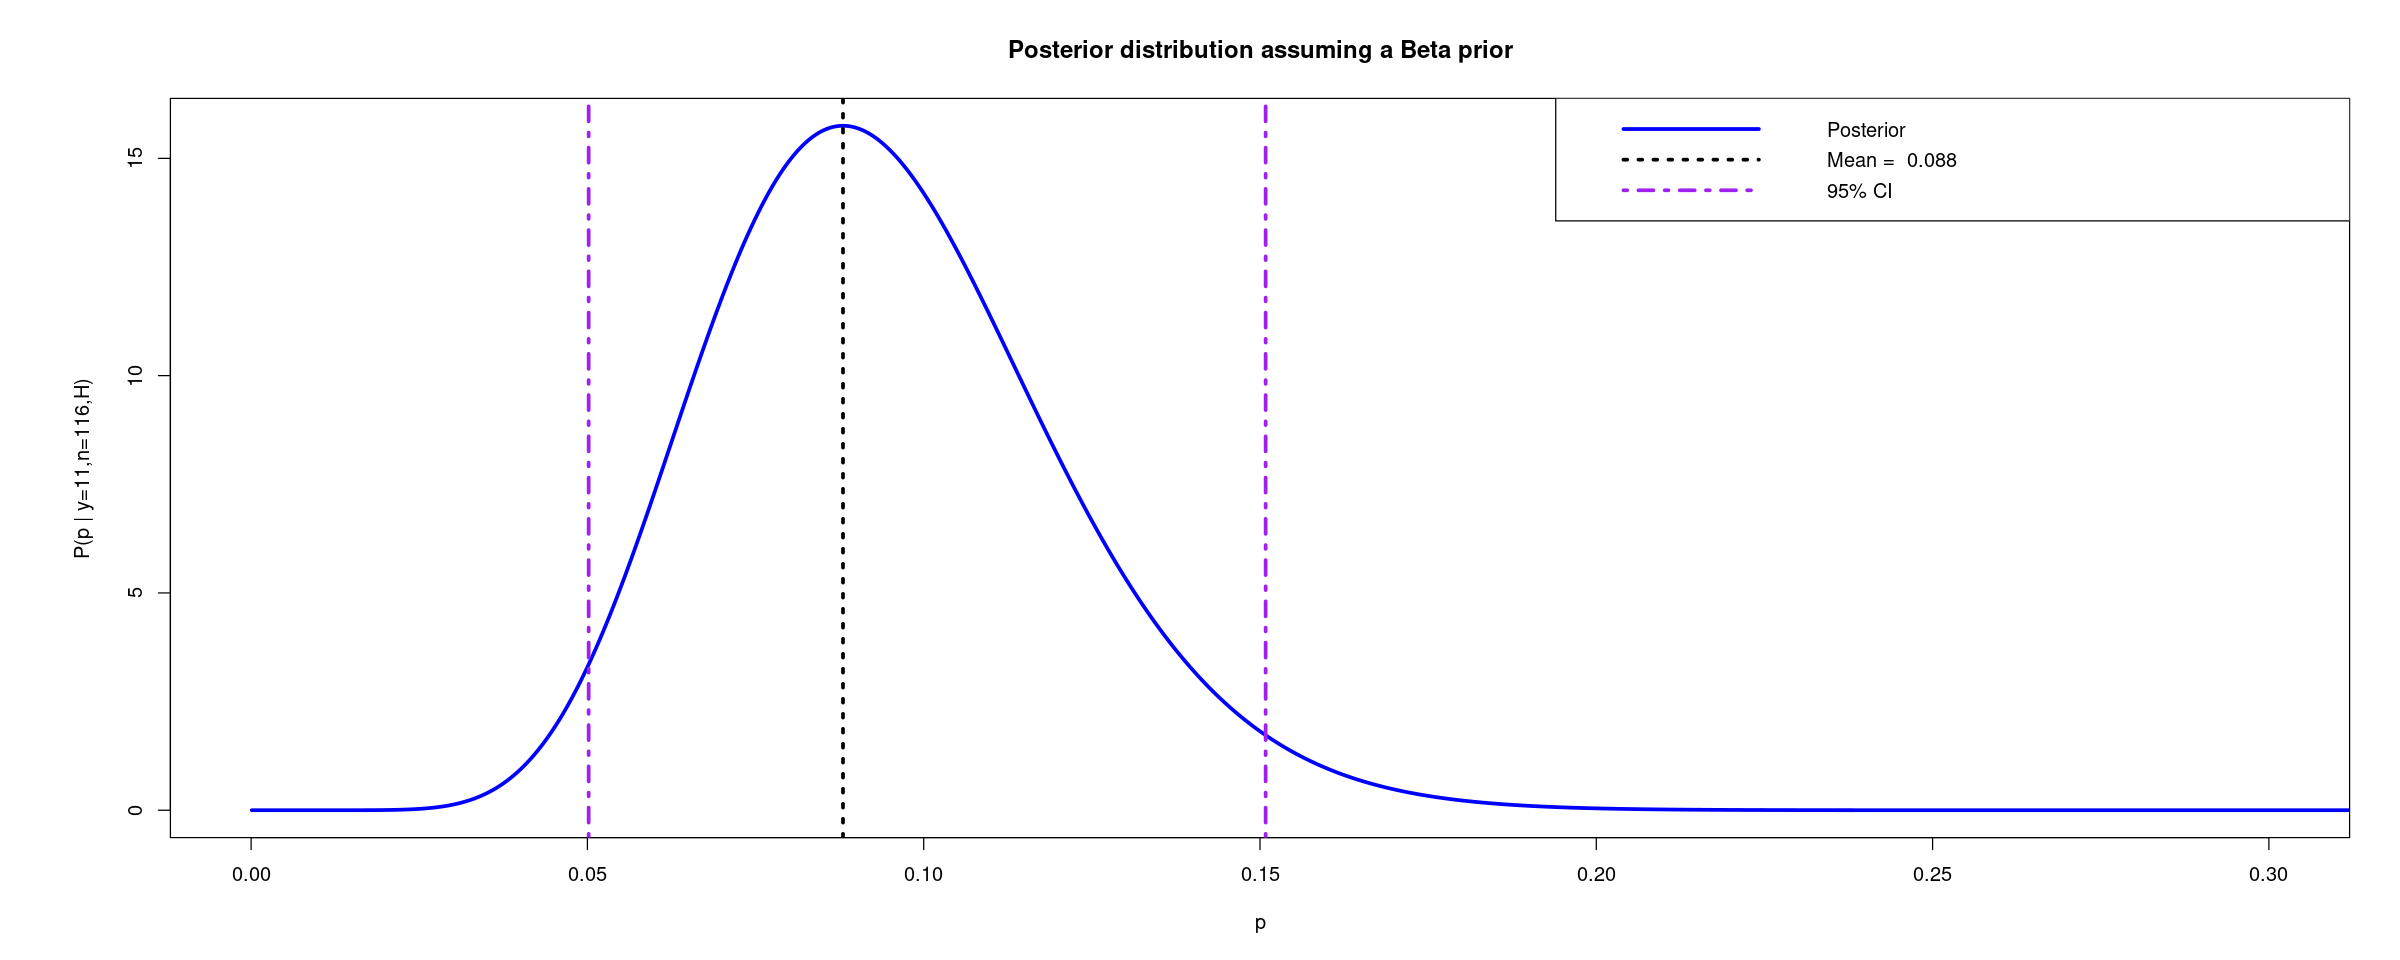

In [17]:
# Then I show the situation before going to the hypothesis testing
options(repr.plot.width=20, repr.plot.height=8)
par(oma = c(0, 3, 0, 0))
plot(x, beta_post, col='blue', type='l', lty=1, lwd=3, xlab="p", ylab= expression (paste(P^symbol(""), "(p | y=11,n=116,H)")), xlim = c(0, 0.3),
        main = 'Posterior distribution assuming a Beta prior')
abline(v=c(bayes_mean, q_lower, q_upper), col=c("black", "purple", "purple"), lty=c(3,4,4), lwd=c(3,3,3))
legend("topright", legend = c("Posterior", paste("Mean = ", round(bayes_mean, 3)), "95% CI"), col = c("blue", "black", "purple"),
        lty = c(1, 3, 4), lwd = c(3, 3, 3))


$\bold{d)}$ Now I have to test the null hypothesis $ H_0 : p = 0.1 $  at a $5\%$ significance level in two ways

I start from the **Frequentist** approach

In [18]:
# I define the useful parameters
p_limit = 0.1
significance = 0.05


In [19]:
# FREQUENTIST APPROACH

# In the frequentist approach it is very easy to find the result, passing through the p-value, which is defined as
# the sum of the probabilities of being less or equal to the y = 11 head values
less_values = seq(0, y, 1)
p_value = sum(dbinom(less_values, size = n, p = p_limit))

cat("The p-value is equal to", p_value, "\n")

if (p_value < significance) {
    cat("The null hypothesis is rejected with significance", significance*100, "%\n")
} else {
    cat("The null hypothesis cannot be rejected with significance", significance*100, "%\n")
}


The p-value is equal to 0.5043125 
The null hypothesis cannot be rejected with significance 5 %


For the **Bayesian** approach I only have to compare the null hypothesis with the $90\%$ credibility interval: in fact I should integrate the function up to the wanted probability $p_0$ and see if it is in one of the tails. But I can look for the credibility interval that cuts the distribution at the significance: now, if the probability is in this interval, then the null hypothesis cannot be rejected, otherwise it can.

In [20]:
# BAYESIAN APPROACH
q_lower_90 = qbeta(significance, shape1 = new_alpha, shape2 = new_beta)
q_upper_90 = qbeta(1 - significance, shape1 = new_alpha, shape2 = new_beta)


cat('The 90% credibility interval is: [', q_lower, ',', q_upper, ']\n')

if( (q_lower_90 < p_limit) & (p_limit < q_upper_90) ) {
    cat('The null hypotesis cannot be rejected with a ', round(significance*100,2),'% significance\n')
} else {
    cat('The null hypotesis is rejected with a ', round(significance*100,2),'% significance\n') 
}
  

The 90% credibility interval is: [ 0.05018522 , 0.1508379 ]
The null hypotesis cannot be rejected with a  5 % significance


For the second part of the exercise I recicle the previous written code

In [21]:
# I define the parameters of the distribution
n = 165
y = 9

# And for request f, I load the parameters
old_alpha = new_alpha; old_beta = new_beta

$\bold{e)}$ The frequentist estimator for $p$ is:

In [22]:
# It is given by theory:
freq_p = y/n
freq_var = freq_p*(1-freq_p)/n

cat("The estimator for p is ", round(freq_p, 3), "+-", round(sqrt(freq_var), 3))

The estimator for p is  0.055 +- 0.018

$\bold{f)}$ The posterior distribution is retrieved from theory, knowing that the posterior is a beta, since we have a beta prior in a bernoulli process (result of a yes/no test)

In [23]:
# From theory I write directly the posterior with changed parameters
alpha = 1; beta = 10

new_alpha = alpha + y
new_beta = beta + n - y

dx = 0.0001 
x = seq(dx, 1, dx)
beta_post = dbeta(x, shape1 = new_alpha, shape2 = new_beta)

While assuming as a prior the posterior of the previous problem, I obtain another beta distrubition, but with different parameters

In [24]:
# From theory I write directly the posterior with changed parameters
old_new_alpha = old_alpha + y
old_new_beta = old_beta + n - y

old_beta_post = dbeta(x, shape1 = old_new_alpha, shape2 = old_new_beta)

$\bold{g)}$ I can then retrieve the bayesian estimator using the posterior distribution, as well as the mean, variance and credibility interval.


In [25]:
# As done for the frequentistic approach, I use the theory to retrieve the results:
bayes_mean = (new_alpha - 1)/(new_alpha + new_beta - 2)
bayes_var = 1/(1/(new_alpha - 1) + 1/(new_beta - 1))/(new_alpha + new_beta - 2)**2
bayes_std = sqrt(bayes_var)

cat('The best estimator for the NEW beta distribution is the mean:', bayes_mean, 'with a variance of:', bayes_var, '\n')

# To retrieve the Confidence interval I use the R given function for the quantile search
q_lower = qbeta(CI[1], shape1 = new_alpha, shape2 = new_beta)
q_upper = qbeta(CI[2], shape1 = new_alpha, shape2 = new_beta)

cat('With a credibility interval of: [', q_lower, ',', q_upper, ']\n')

The best estimator for the NEW beta distribution is the mean: 0.05172414 with a variance of: 0.0002818894 
With a credibility interval of: [ 0.02773918 , 0.09538012 ]


In [26]:
# I do the same for the prior that is the previous beta posterior
old_bayes_mean = (old_new_alpha - 1)/(old_new_alpha + old_new_beta - 2)
old_bayes_var = 1/(1/(old_new_alpha - 1) + 1/(old_new_beta - 1))/(old_new_alpha + old_new_beta - 2)**2
old_bayes_std = sqrt(old_bayes_var)

cat('The best estimator for the NEW beta distribution is the mean:', old_bayes_mean, 'with a variance of:', old_bayes_var, '\n')

# To retrieve the Confidence interval I use the R given function for the quantile search
old_q_lower = qbeta(CI[1], shape1 = old_new_alpha, shape2 = old_new_beta)
old_q_upper = qbeta(CI[2], shape1 = old_new_alpha, shape2 = old_new_beta)

cat('With a credibility interval of: [', old_q_lower, ',', old_q_upper, ']\n')

The best estimator for the NEW beta distribution is the mean: 0.06896552 with a variance of: 0.0002214113 
With a credibility interval of: [ 0.04522356 , 0.1041519 ]


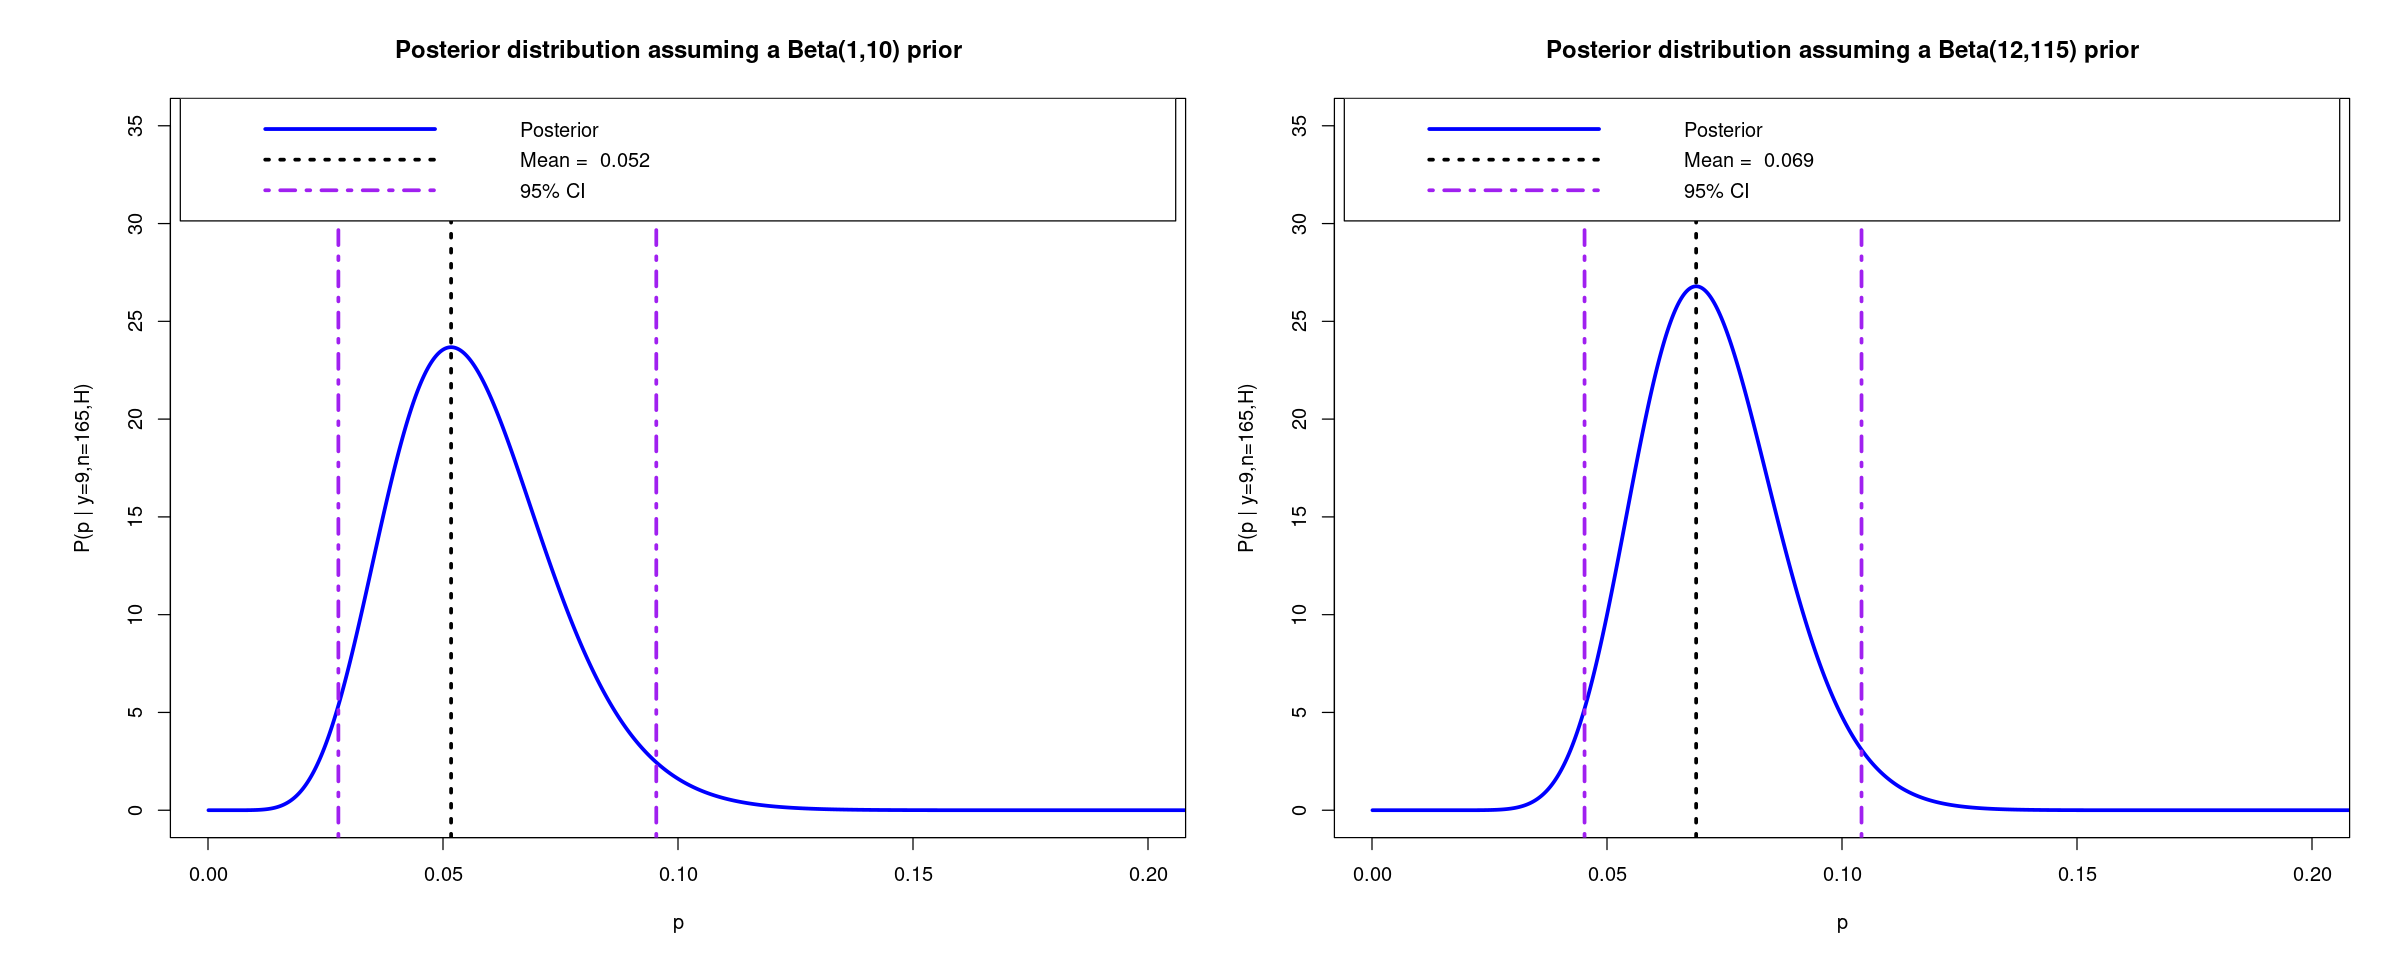

In [27]:
# Then I show the situation before going to the hypothesis testing
options(repr.plot.width=20, repr.plot.height=8)
par(mfrow = c(1, 2), oma = c(0, 3, 0, 0))

plot(x, beta_post, col='blue', type='l', lty=1, lwd=3, xlab="p", ylab= expression (paste(P^symbol(""), "(p | y=9,n=165,H)")), xlim = c(0, 0.2), ylim = c(0, 35),
        main = 'Posterior distribution assuming a Beta(1,10) prior')
abline(v=c(bayes_mean, q_lower, q_upper), col=c("black", "purple", "purple"), lty=c(3,4,4), lwd=c(3,3,3))
legend("top", legend = c("Posterior", paste("Mean = ", round(bayes_mean, 3)), "95% CI"), col = c("blue", "black", "purple"),
        lty = c(1, 3, 4), lwd = c(3, 3, 3))

plot(x, old_beta_post, col='blue', type='l', lty=1, lwd=3, xlab="p", ylab= expression (paste(P^symbol(""), "(p | y=9,n=165,H)")), xlim = c(0, 0.2), ylim = c(0, 35),
        main = 'Posterior distribution assuming a Beta(12,115) prior')
abline(v=c(old_bayes_mean, old_q_lower, old_q_upper), col=c("black", "purple", "purple"), lty=c(3,4,4), lwd=c(3,3,3))
legend("top", legend = c("Posterior", paste("Mean = ", round(old_bayes_mean, 3)), "95% CI"), col = c("blue", "black", "purple"),
        lty = c(1, 3, 4), lwd = c(3, 3, 3))


$\bold{h)}$ Now I have to test the null hypothesis $ H_0 : p = 0.1 $  at a $5\%$ significance level in two ways

I start from the **Frequentist** approach

In [28]:
# I define the useful parameters
p_limit = 0.1
significance = 0.05


In [29]:
# FREQUENTIST APPROACH

# In the frequentist approach it is very easy to find the result, passing through the p-value, which is defined as
# the sum of the probabilities of being less or equal to the y = 9 head values
less_values = seq(0, y, 1)
p_value = sum(dbinom(less_values, size = n, p = p_limit))

cat("The p-value is equal to", p_value, "\n")

if (p_value < significance) {
    cat("The null hypothesis is rejected with significance", significance*100, "%\n")
} else {
    cat("The null hypothesis cannot be rejected with significance", significance*100, "%\n")
}


The p-value is equal to 0.0274604 
The null hypothesis is rejected with significance 5 %


As done before, for the **Bayesian** approach I compare the null hypothesis with the $90\%$ credibility interval.

In [30]:
# BAYESIAN APPROACH for beta(1, 10)
q_lower_90 = qbeta(significance, shape1 = new_alpha, shape2 = new_beta)
q_upper_90 = qbeta(1 - significance, shape1 = new_alpha, shape2 = new_beta)


cat('The 90% credibility interval is: [', q_lower_90, ',', q_upper_90, ']\n')

if( (q_lower_90 < p_limit) & (p_limit < q_upper_90) ) {
    cat('The null hypotesis cannot be rejected with a ', round(significance*100,2),'% significance\n')
} else {
    cat('The null hypotesis is rejected with a ', round(significance*100,2),'% significance\n') 
}
  

The 90% credibility interval is: [ 0.03132615 , 0.0880266 ]
The null hypotesis is rejected with a  5 % significance


In [31]:
# BAYESIAN APPROACH for beta(12, 115)
old_q_lower_90 = qbeta(significance, shape1 = old_new_alpha, shape2 = old_new_beta)
old_q_upper_90 = qbeta(1 - significance, shape1 = old_new_alpha, shape2 = old_new_beta)


cat('The 90% credibility interval is: [', old_q_lower_90, ',', old_q_upper_90, ']\n')

if( (old_q_lower_90 < p_limit) & (p_limit < old_q_upper_90) ) {
    cat('The null hypotesis cannot be rejected with a ', round(significance*100,2),'% significance\n')
} else {
    cat('The null hypotesis is rejected with a ', round(significance*100,2),'% significance\n') 
}
  

The 90% credibility interval is: [ 0.04886328 , 0.09830535 ]
The null hypotesis is rejected with a  5 % significance


This means that in both cases the Null Hypothesis can be rejected with a significance of $5\%$

# Exercise 4

Analyze the data of Exercise 3 and solve points (b) and (c) using a MCMC with JAGS

In [32]:
# I take the informations useful to use rjags program
y = 11
n = 116


$\bold{b)}$ For the point (b) I only need rjags to create a beta distribution $\text{Beta}(1, 10)$

In [33]:
# Then I create a vector containing the observed data: y heads and (n-y) tails
X = c(rep(1,y), rep(0,n-y))

# And I set the informations to be given to the program
jdata = NULL
jdata$X = X
jdata$n = length(X)

# And I create the model 
jags_b = jags.model('ex06_les05.bug', jdata)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 116
   Unobserved stochastic nodes: 1
   Total graph size: 120

Initializing model



In [34]:
# Bur-in of 1000 required 
update(jags_b, 1000)

# Creation of the rjags created chain
chain_b = coda.samples(jags_b, c("p"), n.iter=10000)
print(summary(chain_b))



Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0947963      0.0258743      0.0002587      0.0002587 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.05023 0.07626 0.09242 0.11093 0.15150 



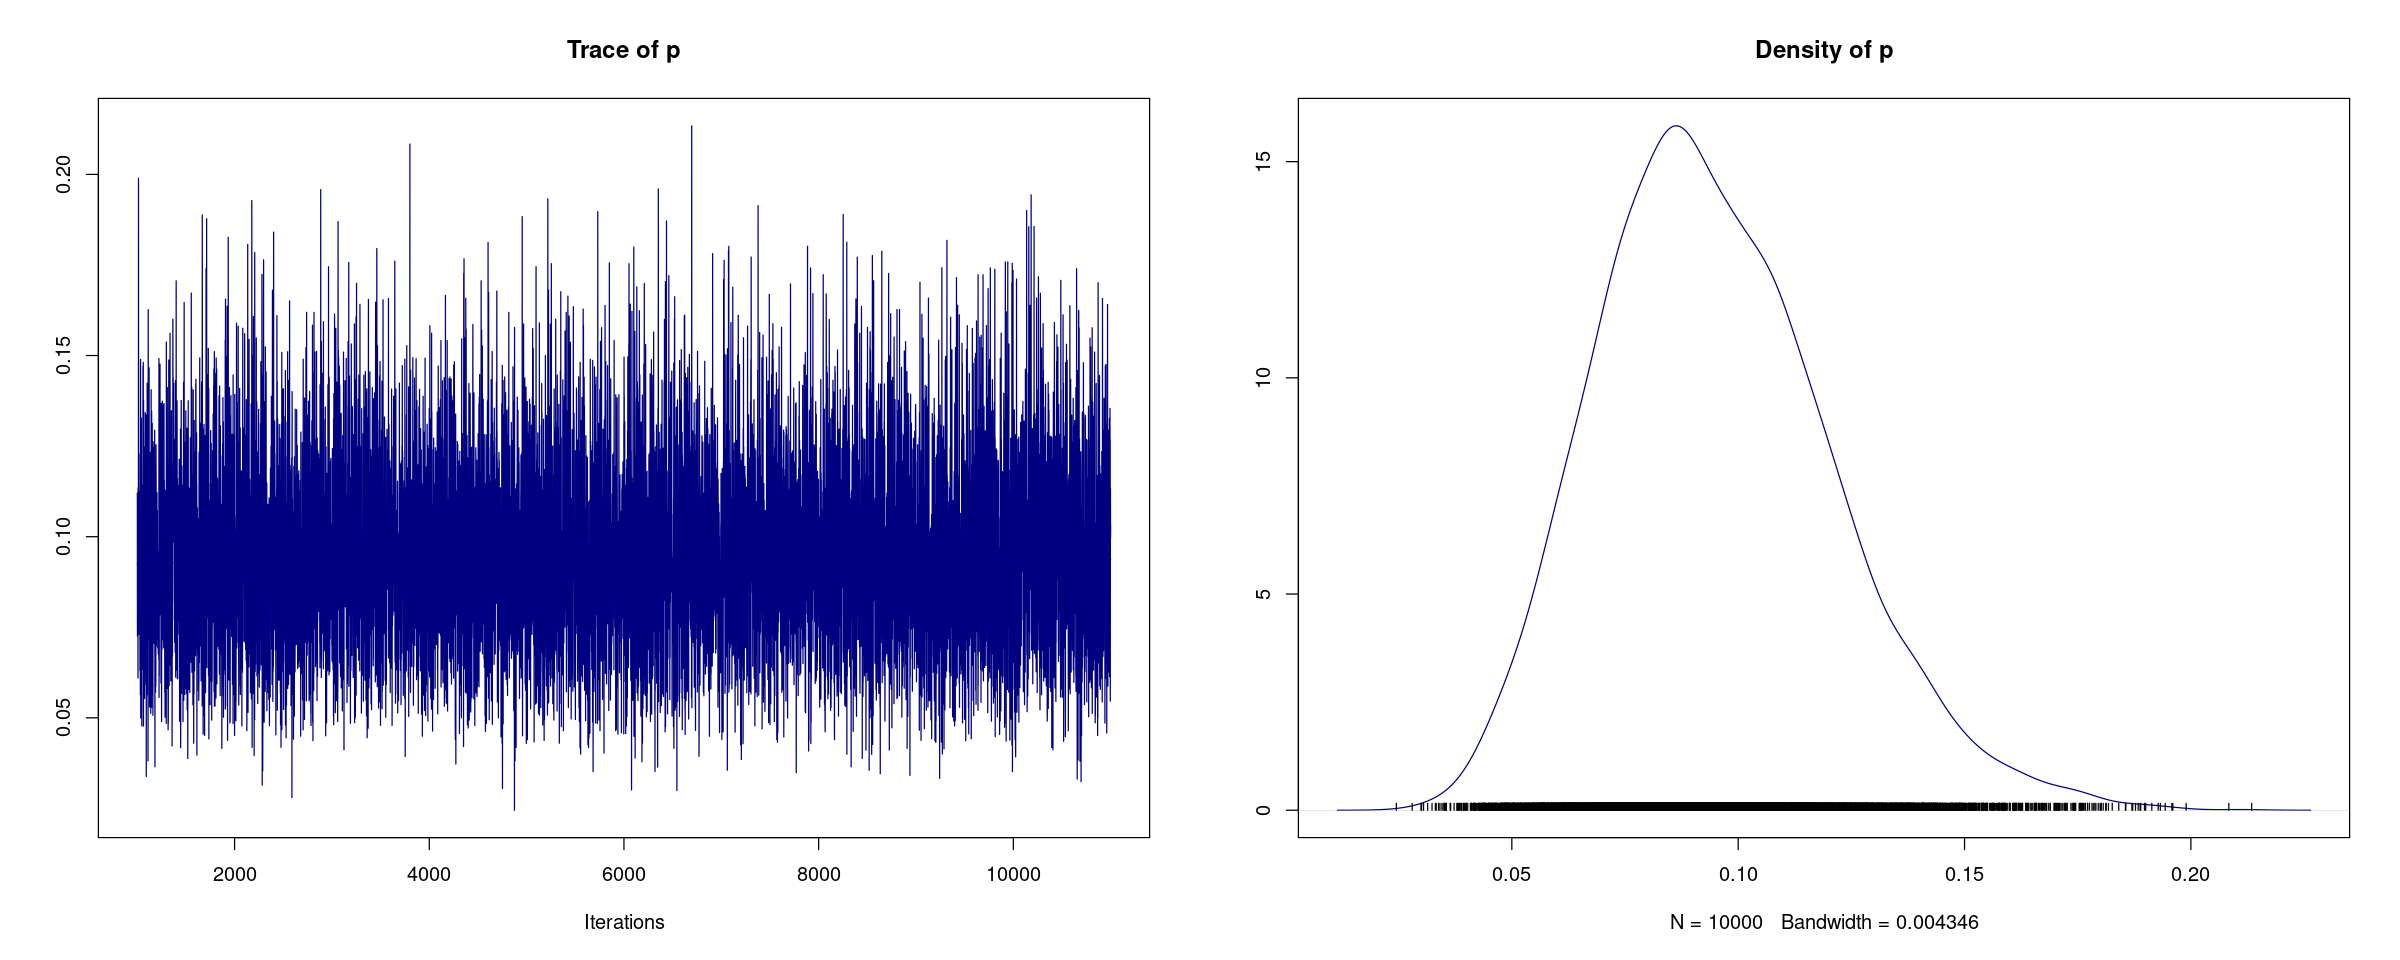

In [35]:
# To show the goodness of the evaluations, I present the plot of the trace and the resulting density of the searched variable
options(repr.plot.width=20, repr.plot.height=8)
plot(chain_b, col="navy")


$\bold{c)}$ For the point (c) I only need to analize the previous chain

In [36]:
# I can then save the chain informations as dataframe
chain_b_df = as.data.frame( as.mcmc(chain_b) )

# And retrieve the quantile ones from the summary
results = summary(chain_b)

In [37]:
# Now I want to use sapply to retrieve mean, variation and standard deviation of the df
chain_mean = sapply(chain_b_df, mean)
chain_var = sapply(chain_b_df, var)
chain_std = sqrt(chain_var)

lower_q = results$quantiles[1]
upper_q = results$quantiles[5]

cat("The bes t estimator for the MCMC result is the mean", chain_mean, "with variance", chain_var,
    "\nThe Confidence interval is therefore [", lower_q, ",", upper_q,"]")


The bes t estimator for the MCMC result is the mean 0.09479632 with variance 0.0006694819 
The Confidence interval is therefore [ 0.05023221 , 0.151505 ]